# Computational Physics Blatt 03
Anne, Fabian und Asliddin 

## Aufgabe 0

Symplectic integration methods are a class of numerical techniques for solving differential equations, particularly prevalent in classical mechanics and celestial mechanics. In order to solve the Newtonian equations of motion in an MD simulation, the Verlet algorithm is employed, which is also symplectic. These algorithms perform canonical transformations at each time step and exhibit long-term stability and robustness. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams["figure.figsize"] = (10, 10)
%matplotlib inline

DIM = 3 # Number of dimensions, relevant for the indeces of y


def gravitation(delta_r, m1, m2, G=1):
    r_norm = np.linalg.norm(delta_r)
    return G * m1 * m2 * delta_r / r_norm**3


def graviWrap(t, y, m1=1, m2=1e-10, G=1):
    # Splitting the vector y into the four vectors r1, r2, p1, p2
    r1 = y[0:DIM]
    r2 = y[DIM : 2 * DIM]
    p1 = y[2 * DIM : 3 * DIM]
    p2 = y[3 * DIM : 4 * DIM]
    delta_r = r2 - r1
    p1_dot = gravitation(delta_r, m1, m2, G=G)
    p2_dot = -p1_dot
    r1_dot = p1 / m1
    r2_dot = p2 / m2
    return np.concatenate((r1_dot, r2_dot, p1_dot, p2_dot))

In [2]:
def rungeKutta4(
    f, y0, t0, h, t_max, **kwargs
):  # Generator for the recursive Rubnge-Kutta 4th order method.
    y = y0
    t_n = t0
    t_n1 = t_n + h  # in Latex: t_{n+1}
    t_n12 = t_n + h / 2  # in Latex: t_{n+1/2}
    while t_n < t_max:
        k1 = h * f(t_n, y, **kwargs)
        k2 = h * f(t_n12, y + 0.5 * k1, **kwargs)
        k3 = h * f(t_n12, y + 0.5 * k2, **kwargs)
        k4 = h * f(t_n1, y + k3, **kwargs)
        y = y + (k1 + 2 * k2 + 2 * k3 + k4) / 6
        t_n = t_n1
        t_n1 = t_n + h
        t_n12 = t_n + h / 2
        yield t_n, y

## a)

The gravitational Force is given by
\begin{align}
    \ddot{r}_\mathrm{i}m_\mathrm{i} &= -G\frac{m_\mathrm{i}m_\mathrm{j}}{\left|r_\mathrm{i}- r_\mathrm{j}\right|^3}(r_\mathrm{i}- r_\mathrm{j}) \\
    \Leftrightarrow \ddot{r}_\mathrm{i} &= -G\frac{m_\mathrm{j}}{\left|r_\mathrm{i}- r_\mathrm{j}\right|^3}(r_\mathrm{i}- r_\mathrm{j}) \\
\end{align}
By using $y = (r,p)^\mathrm{T}$ we can simplify this differential equation of rank 2 to two differential equations of rank 1
\begin{align}
y_\mathrm{i} &= \begin{pmatrix}
    r_\mathrm{i} \\
    p_\mathrm{i}
    \end{pmatrix} \\
\Rightarrow \dot{r}_\mathrm{i} &= \frac{p_\mathrm{i}}{m_\mathrm{i}} \\
\Rightarrow \dot{p_\mathrm{i}} &= -G\frac{m_\mathrm{j}}{\left|r_\mathrm{i}- r_\mathrm{j}\right|^3}(r_\mathrm{i}- r_\mathrm{j}) \\
\end{align}

In [3]:
r0_Planet = np.array([0, 0, 0])
r0_RS = np.array([1.1, 0, 0])
p0_Planet = np.array([0, 0, 0])
p0_RS = np.array([0, 1e-12, 0])
m_PLanet = 1
m_RS = 1e-10

y_0 = np.concatenate((r0_Planet, r0_RS, p0_Planet, p0_RS))
system = rungeKutta4(graviWrap, y_0, t0=0, h=0.001, t_max=100, m1=m_PLanet, m2=m_RS)
run1 = [(t, y) for (t, y) in system]
time, trajectory = zip(*run1)
time = np.array(time)
trajectory = np.array(trajectory)

Text(0.5, 1.0, 'Starting with to low velocity')

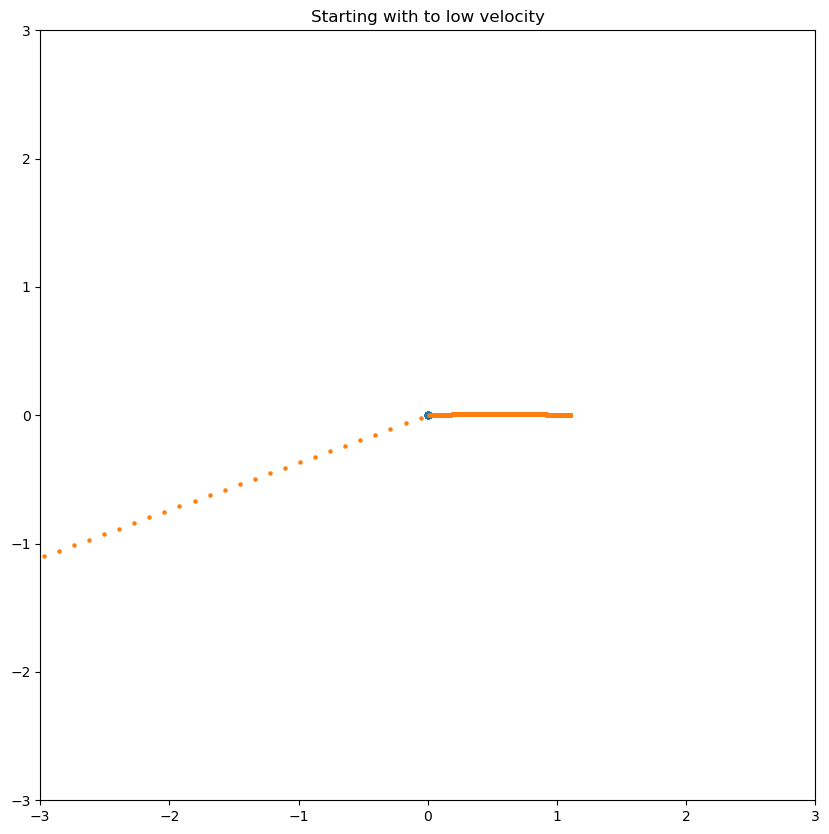

In [4]:
plt.scatter(trajectory[:, 0], trajectory[:, 1], s=20)
plt.scatter(trajectory[:, 3], trajectory[:, 4], s=5)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.title("Starting with to low velocity")

In [5]:
r0_Planet = np.array([0, 0, 0])
r0_RS = np.array([1.1, 0, 0])
p0_Planet = np.array([0, 0, 0])
p0_RS = np.array([0, 1e-10, 0])
m_PLanet = 1
m_RS = 1e-10

y_0 = np.concatenate((r0_Planet, r0_RS, p0_Planet, p0_RS))
system = rungeKutta4(graviWrap, y_0, t0=0, h=0.001, t_max=100, m1=m_PLanet, m2=m_RS)
run2 = [(t, y) for (t, y) in system]
time, trajectory = zip(*run2)
time = np.array(time)
trajectory = np.array(trajectory)

Text(0.5, 1.0, 'Starting with correct velocity')

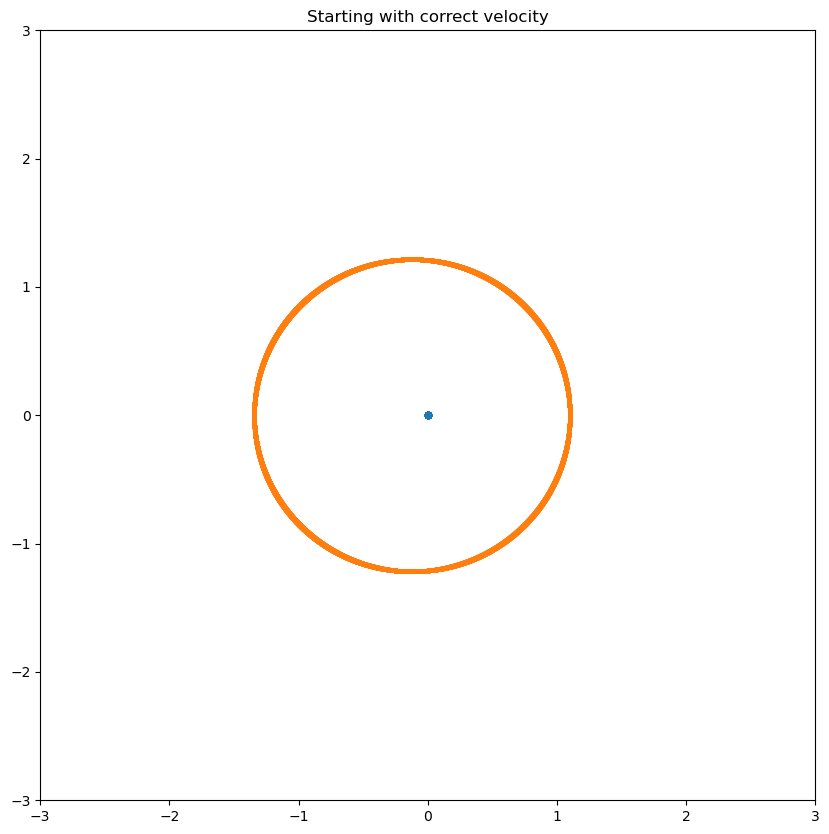

In [6]:
plt.scatter(trajectory[:, 0], trajectory[:, 1], s=20)
plt.scatter(trajectory[:, 3], trajectory[:, 4], s=5)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.title("Starting with correct velocity")

When starting with to little velocity, the space station crashes in the planet, as it should.

In this simulation, the station can pass thru the planet at extreme velocity.
Because our $h$ is to big for this rate of change, we miss the very important moments of big deceleration and the station escapes. 

## b)

Numerically verify energy conservation and the second Kepler law and plot the temporal evolution of these quantities.

The kinetic energy:
\begin{align*}
    E_{k}= \frac{1}{2} m v^2
\end{align*}
The potential energy:
\begin{align*}
    E_{P}= - \frac{G \cdot m_1 m_2}{r}
\end{align*}
The second Kepler's law:
\begin{align*}
    L = r \times p
\end{align*}

 



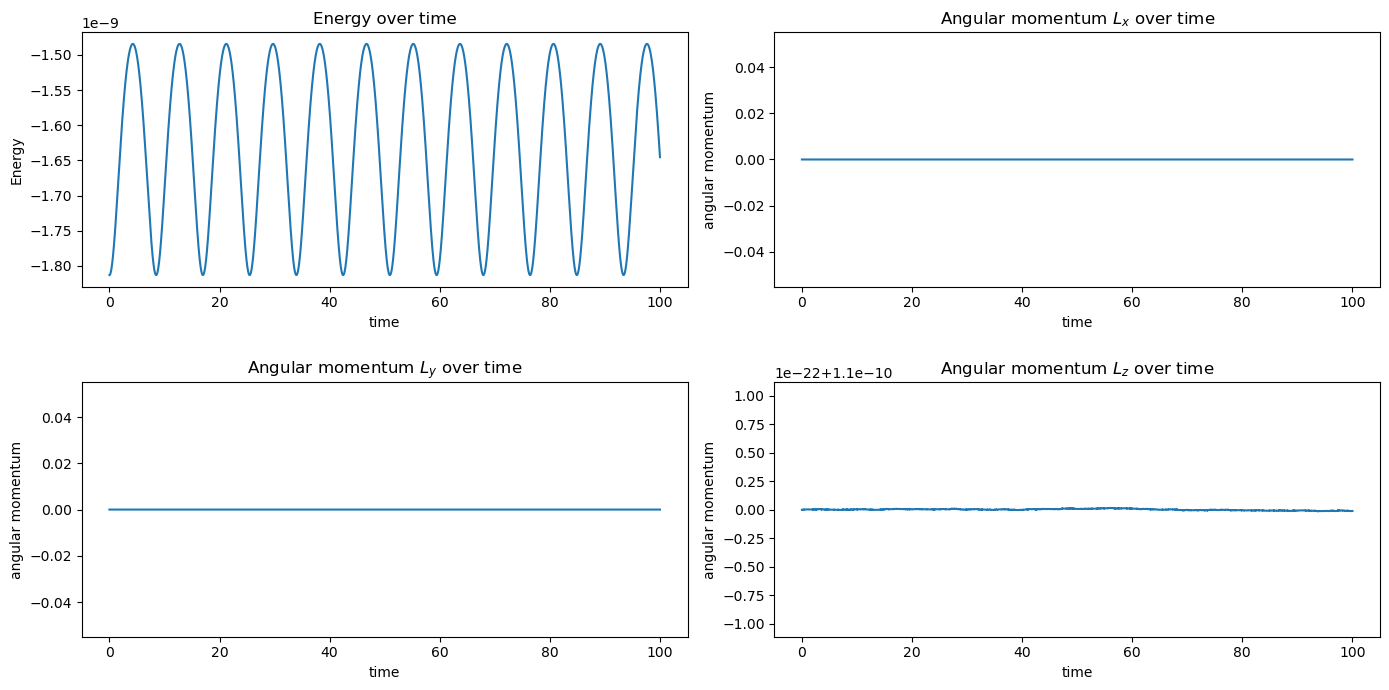

In [24]:
G = 1
# calculation of the energies and angular momentum using the velocity components from task a
kinetic_energy_RS = np.linalg.norm(trajectory[:, 9:12], axis=1) ** 2 / (2 * m_RS)
kinetic_energy_Planet = np.linalg.norm(trajectory[:, 6:9], axis=1) ** 2 / (2 * m_PLanet)
potential_energy = (
    -G
    * m_PLanet
    * m_RS
    / np.linalg.norm(trajectory[:, 3:6] - trajectory[:, 0:3], axis=1)
)


total_energy = kinetic_energy_Planet + 2 * potential_energy + kinetic_energy_RS

Second_kepler = np.cross(trajectory[:, 3:6], trajectory[:, 9:12]) + np.cross(
    trajectory[:, 0:3], trajectory[:, 6:9]
)


plt.figure(figsize=(14, 7))

plt.subplot(2, 2, 1)
plt.plot(time, total_energy)
plt.xlabel("time")
plt.ylabel("Energy")
plt.title("Energy over time")

plt.subplot(2, 2, 2)
plt.plot(time, Second_kepler[:, 0])
plt.xlabel("time")
plt.ylabel("angular momentum")
plt.title("Angular momentum $L_x$ over time")

plt.subplot(2, 2, 3)
plt.plot(time, Second_kepler[:, 1])
plt.xlabel("time")
plt.ylabel("angular momentum")
plt.title("Angular momentum $L_y$ over time")
plt.subplot(2, 2, 4)
plt.plot(time, Second_kepler[:, 2])
plt.xlabel("time")
plt.ylabel("angular momentum")
plt.title("Angular momentum $L_z$ over time")
plt.tight_layout()
plt.show()

## c) 
Lenz Runge vector: 
\begin{align*}
    \Lambda = \frac{1}{Gm} \vec{p} \times \vec{L} - \frac{\vec{r}}{r}
\end{align*}

In [8]:
G = 1
m_RS = 10e-10


def lenz_runge_vector(p, L, r, r0_Planet):

    r_betrag = np.linalg.norm(r, axis=1)
    r_berechnung = r / r_betrag[:, None]
    lenz_runge = 1 / (G * m_RS) * np.cross(p, L)

    lenz_runge_vec = lenz_runge - r_berechnung

    return lenz_runge_vec


# lenz_runge_vec = lenz_runge_vector(m_RS * trajectory[:, 6:9], trajectory[:, : 3], trajectory[:, :3])